In [1]:
import numpy as np
import librosa
from scipy.signal import get_window
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 5)

#### "Import" some functions from Exercise 1 (using an ugly hack)

In [123]:
from pathlib import Path
import json


def cleanup_cell(cell: str, function_name: str) -> str:
    """
    Remove lines that do not belong to function function_name
    Start from the line with "def function_name" and go until the indentation
    level is the same as the "def function_name" line
    """
    lines = cell.split("\n")
    indentation_level = 0
    start_i = 0
    end_i = None

    def get_indentation_level(line: str) -> int:
        """# of spaces at the beginning of line"""
        return len(line) - len(line.lstrip(" "))

    for i, line in enumerate(lines):
        if f"def {function_name}" in line:
            indentation_level = get_indentation_level(line)
            start_i = i
            break

    for i, line in enumerate(lines[start_i + 1 :]):
        if get_indentation_level(line) == indentation_level:
            if line.strip() == "" or line.lstrip()[0] in ["#", ")"]:
                continue
            end_i = i + start_i
            break

    lines = lines[start_i:end_i]
    lines = [line[indentation_level:] for line in lines]
    return "\n".join(lines).strip()


def import_function_from_ipynb(notebook_name: str, function_names: list[str]):
    try:
        # try to find notebook_name in parent directory tree
        ex1_path = Path.cwd().parent.rglob(f"{notebook_name}")
        ex1_path = list(ex1_path)[0]
    except IndexError:
        raise FileNotFoundError("{notebook_name} not found in parent directory tree")

    print(f"Found {notebook_name}: {ex1_path}")

    funcs_found = []

    # read notebook_name
    with open(ex1_path, "r") as f:
        ex1 = f.read()

    ex1 = json.loads(ex1)

    # search all cells for the one that contains "def function_name"
    for cell in ex1["cells"]:
        cell_src = "".join(cell["source"])
        for function_name in function_names:
            if f"def {function_name}(" in cell_src:
                exec(cleanup_cell(cell_src, function_name), globals())
                print(f"Executed function {function_name}")
                funcs_found.append(function_name)

    print(f"Successfully imported functions: {funcs_found}")
    if len(funcs_found) != len(function_names):
        print(len(funcs_found), len(function_names))
        print(f"Could not find functions: {list(set(function_names) - set(funcs_found))}")


import_function_from_ipynb(
    "exercise1.ipynb",
    [
        "my_windowing",
        "acf",
        "estimate_fundamental_frequency",
        "plot_signal",
    ],
)


Found exercise1.ipynb: /Users/imran/Desktop/studies/suse_23/speech_sp/Exercise1/exercise1.ipynb
Executed function plot_signal
Executed function my_windowing
Executed function acf
Executed function estimate_fundamental_frequency
Successfully imported functions: ['plot_signal', 'my_windowing', 'acf', 'estimate_fundamental_frequency']


In [3]:
my_windowing, acf, estimate_fundamental_frequency

(<function __main__.my_windowing(v_signal: numpy.ndarray, sampling_rate: int, frame_length: int, frame_shift: int = None) -> tuple[numpy.ndarray, numpy.ndarray]>,
 <function __main__.acf(frames)>,
 <function __main__.estimate_fundamental_frequency(acf_frames: numpy.ndarray, sampling_freq: int, min_freq: float = 80, max_freq: float = 400) -> numpy.ndarray>)

## 1. Short-time Fourier Transform

In [4]:
def compute_stft(
    v_signal: np.ndarray,
    fs: int,
    frame_length: int,
    frame_shift: int,
    v_analysis_window: np.ndarray,
) -> list[np.ndarray]:
    """Compute the short-time Fourier transform of a signal."""
    frames, frame_centers = my_windowing(v_signal, fs, frame_length, frame_shift)
    frames *= v_analysis_window
    spectrum = np.fft.fft(frames, axis=1)
    # remove upper half of the spectrum
    spectrum = spectrum[:, : spectrum.shape[1] // 2 + 1]

    # check with np.fft.rfft
    spectrum2 = np.fft.rfft(frames, axis=1)
    print("Output matches np.fft.rfft:", np.allclose(spectrum, spectrum2))

    return spectrum, frame_centers

In [5]:
s1, sampling_rate = librosa.core.load("Audio/speech1.wav", sr=None)
print(len(s1) / sampling_rate, "s")

s2, sampling_rate = librosa.core.load("Audio/phone.wav", sr=None)
print(len(s2) / sampling_rate, "s")

2.841625 s
2.0 s


In [6]:
m_stft, frame_centers = compute_stft(s1, sampling_rate, 25, 10, np.hamming(25 * sampling_rate // 1000))

Output matches np.fft.rfft: True


## 2. Spectral analysis

### a) Log magnitude spectrogram

In [90]:
def plot_log_spectrogram(
    signal: np.ndarray,
    sampling_rate: int,
    frame_length: int = 32,
    frame_shift: int = 8,
    threshold: float = None,
    plt_show: bool = True,
) -> None:
    """Plot the log spectrogram of a signal."""
    m_stft, v_time = compute_stft(
        signal,
        sampling_rate,
        frame_length,
        frame_shift,
        get_window("hann", frame_length * sampling_rate // 1000),
    )

    magnitude = 10 * np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10 ** (-15)))

    v_freq = np.linspace(0, sampling_rate / 2, magnitude.shape[0])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(
        magnitude,
        cmap="viridis",
        origin="lower",
        extent=[v_time[0], v_time[-1], v_freq[0], v_freq[-1]],
        aspect="auto",
    )

    if threshold is not None:
        # plot parts of the spectrogram that are above the threshold
        ax.contour(
            v_time,
            v_freq,
            magnitude,
            levels=[threshold],
            colors="red",
            linestyles="solid",
            linewidths=1,
        )

    fig.colorbar(im, orientation="vertical", pad=0.01)
    im.colorbar.set_label("Magnitude [dB]", rotation=270, labelpad=15)

    ax.set_title(f"Spectrogram \n (frame length: {frame_length} ms, frame shift: {frame_shift} ms)")
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Frequency [Hz]")
    # ax.set_yscale("log")

    fig.tight_layout()
    if plt_show:
        plt.show()

Output matches np.fft.rfft: True


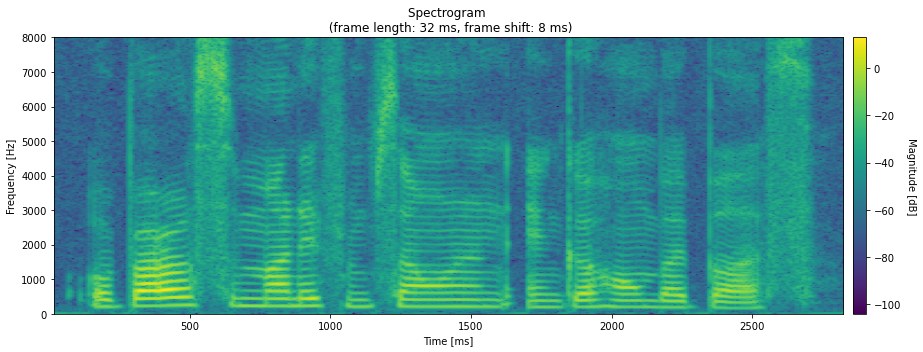

In [91]:
plot_log_spectrogram(s1, sampling_rate, frame_length=32, frame_shift=8)

Output matches np.fft.rfft: True


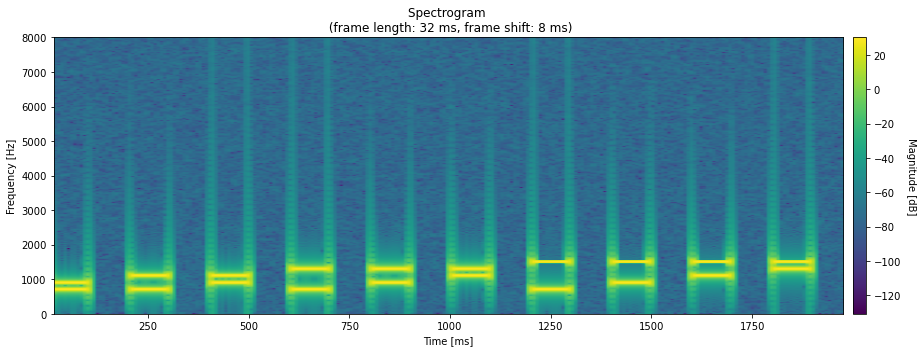

In [92]:
plot_log_spectrogram(s2, sampling_rate, frame_length=32, frame_shift=8)

### c) Frame length = 8 ms, frame shift = 2 ms

Output matches np.fft.rfft: True


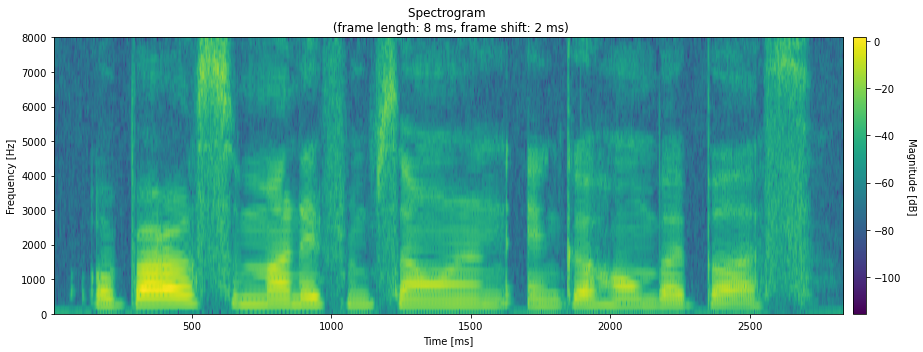

In [93]:
plot_log_spectrogram(s1, sampling_rate, frame_length=8, frame_shift=2)

Output matches np.fft.rfft: True


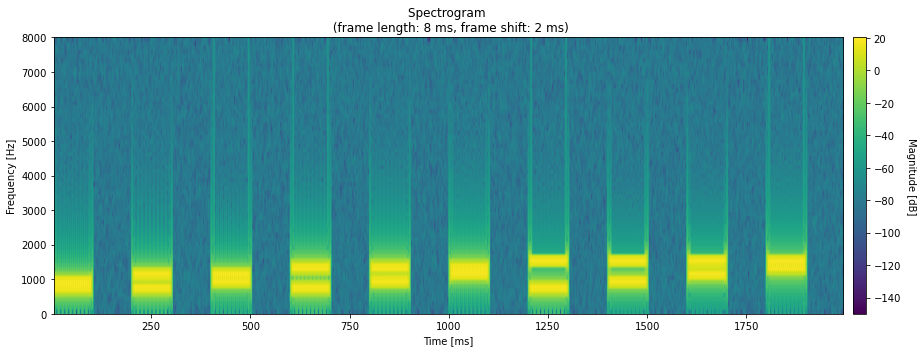

In [94]:
plot_log_spectrogram(s2, sampling_rate, frame_length=8, frame_shift=2)

### c) Frame length = 128 ms, frame shift = 32 ms

Output matches np.fft.rfft: True


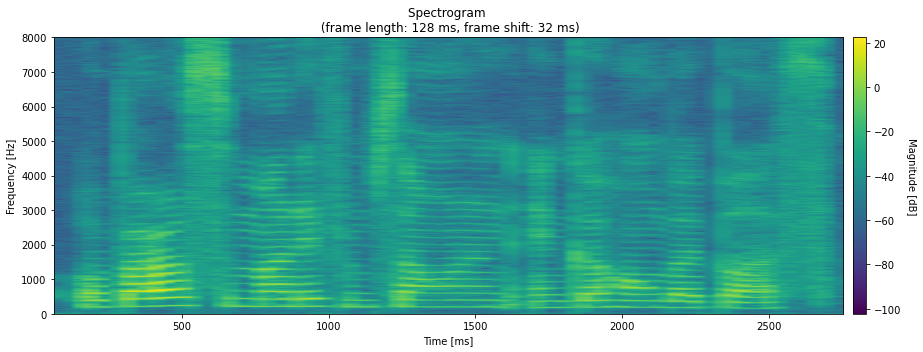

In [95]:
plot_log_spectrogram(s1, sampling_rate, frame_length=128, frame_shift=32)

Output matches np.fft.rfft: True


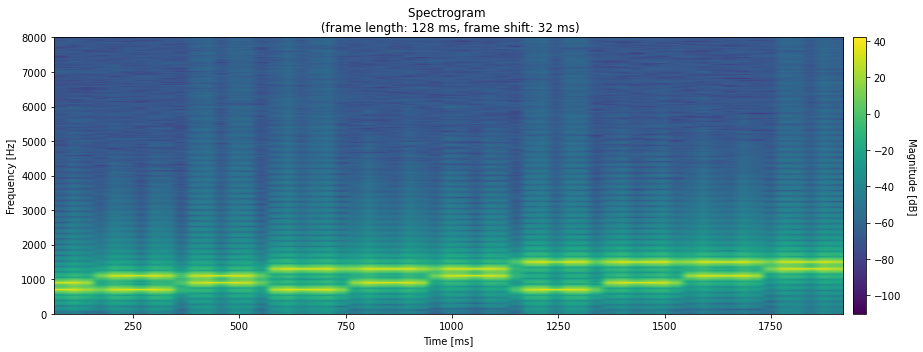

In [96]:
plot_log_spectrogram(s2, sampling_rate, frame_length=128, frame_shift=32)

We can observe the tradeoff between time and frequency resolution: longer frames (windows) give a better frequency resolution at the cost of decreased time resolution.

### d) Fundamental frequency

In [97]:
# compute fundamental frequency
frames, frame_centers = my_windowing(s1, sampling_rate, 32, 8)
acf_frames = acf(frames)
f0 = estimate_fundamental_frequency(acf_frames, sampling_freq=sampling_rate, min_freq=80, max_freq=400)
f0.shape

(352,)

Output matches np.fft.rfft: True


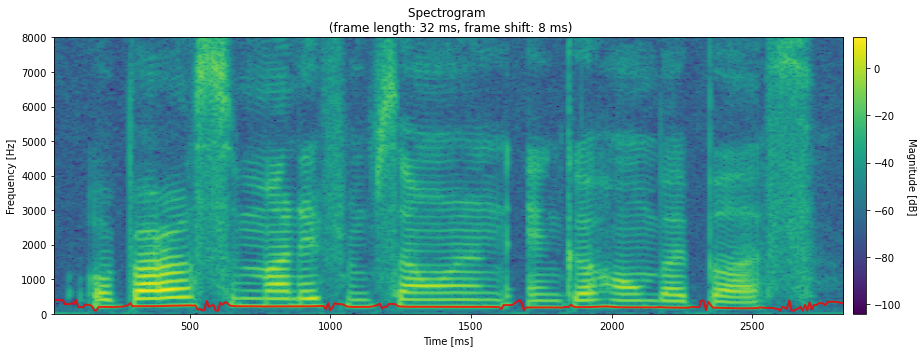

In [106]:
plot_log_spectrogram(s1, sampling_rate, frame_length=32, frame_shift=8, plt_show=False)

# plot fundamental frequency on top of spectrogram
n_harmonics = 1
for i in range(1, n_harmonics + 1):
    plt.plot(frame_centers, f0 * i, color="red", linewidth=2, alpha=0.8)

plt.show()

We can see the fundamental frequency (in red) matches the frequency of the first peak in the spectrum.

Output matches np.fft.rfft: True


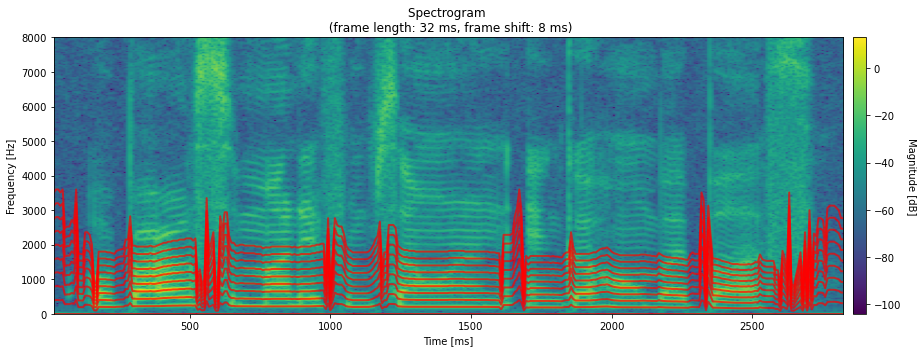

In [107]:
plot_log_spectrogram(s1, sampling_rate, frame_length=32, frame_shift=8, plt_show=False)

# plot fundamental frequency on top of spectrogram
n_harmonics = 10
for i in range(n_harmonics):
    plt.plot(frame_centers, f0 * i, color="red", linewidth=2, alpha=0.7)

plt.show()

With 10 harmonics plotted, the alignment between the peaks and the harmonics is not perfect, but it is still possible to see the harmonics.

## 3) Inverse STFT

In [124]:
from code_exercise2 import compute_istft

### Test signal

In [125]:
frame_length = 32
frame_shift = 16
sampling_rate = 16000

v_test_signal = np.ones(2048)

### 1. STFT of the test signal

In [126]:
sqrt_hann = np.sqrt(get_window("hann", frame_length * sampling_rate // 1000))

m_stft, frame_centers = compute_stft(v_test_signal, sampling_rate, frame_length, frame_shift, sqrt_hann)

Output matches np.fft.rfft: True


### 2. Resynthesis of the test signal

In [143]:
v_reconstructed_signal = compute_istft(m_stft, frame_length, frame_shift, sqrt_hann)
v_reconstructed_signal.shape

(512,)

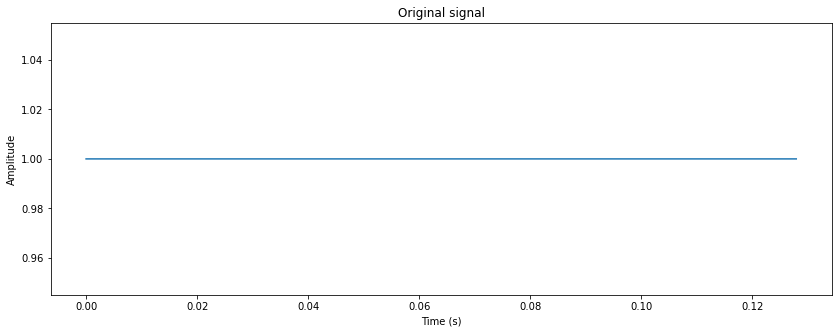

In [140]:
plot_signal(v_test_signal, sampling_rate, title="Original signal")

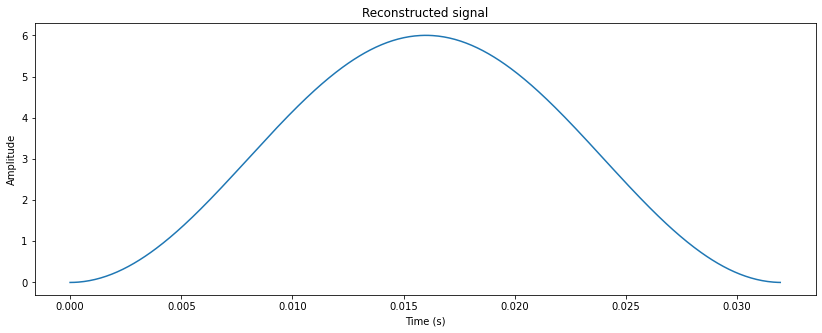

In [141]:
plot_signal(v_reconstructed_signal, sampling_rate, title="Reconstructed signal")

> NOTE: the reconstructed signal has the length of 512, while the original has 2048 samples